# Lab 12-2: Bert Model for Language Understanding
## Exercise: Sentiment Analysis of Movie Reviews
This exercise is taken from TensorFlow Tutorials and modified for data handling.<br>
https://www.tensorflow.org/text/tutorials/classify_text_with_bert

In [1]:
!pip install "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 36.1 MB/s 
     |████████████████████████████████| 1.1 MB 31.8 MB/s 
     |████████████████████████████████| 596 kB 11.5 MB/s 
     |████████████████████████████████| 1.1 MB 51.8 MB/s 
     |████████████████████████████████| 99 kB 8.0 MB/s 
     |████████████████████████████████| 352 kB 47.4 MB/s 
     |████████████████████████████████| 238 kB 56.8 MB/s 
     |████████████████████████████████| 1.2 MB 48.3 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 


In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

Masked Language Modeling is a fill-in-the-blank task, where a model uses the context words surrounding a mask token to try to predict what the masked word should be.<br>
Example:

* Input: "I have watched this [MASK] and it was awesome."
* Output: "I have watched this movie and it was awesome."

Masked language modeling is a great way to train a language model in a self-supervised setting (without human-annotated labels). Such a model can then be fine-tuned to accomplish various supervised NLP tasks.

End-to-end Masked Language Modeling with BERT<br>
https://keras.io/examples/nlp/masked_language_modeling/

Sentiment analysis

Download the IMDB dataset

In [3]:
#from keras.datasets import imdb
batch_size = 32

(ds_train, ds_test, ds_val), ds_info = tfds.load('imdb_reviews',
                                            split=['train', 'test[:80%]', 'test[80%:]'],  # + 'unsupervised'
                                            batch_size=batch_size,
                                            shuffle_files=True, 
                                            as_supervised=True, 
                                            with_info=True)

print(ds_info.features)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteXGPBXN/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteXGPBXN/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteXGPBXN/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
FeaturesDict({
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(), dtype=tf.string),
})


In [4]:
AUTOTUNE = tf.data.AUTOTUNE
seed = 42

ds_train = ds_train.cache().prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.cache().prefetch(buffer_size=AUTOTUNE)
ds_val = ds_val.cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
class_names = ds_info.features['label'].names

for text_batch, label_batch in ds_train.take(1):
    for i in range(3):
        print(f'Review: {text_batch.numpy()[i]}')
        label = label_batch.numpy()[i]
        print(f'Label : {label} ({class_names[label]})')

Review: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Label : 0 (neg)
Review: b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was r

Loading models from TensorFlow Hub
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',        

In BERT uncased, the text has been lowercased before WordPiece tokenization step while in BERT cased, the text is same as the input text (no changes).
BERT uncased is better than BERT cased in most applications except in applications where case information of text is important.
Named Entity Recognition and Part-of-Speech tagging are two applications where case information is important and hence, BERT cased is better in this case.

Letters in naming indicate L for layer, H for hidden dimension, and A for attention head. For example, bert_en_uncased_L-24_H-1024_A-16 model contains L=24 hidden layers (Transformer blocks), a hidden size of H=1024, and A=16 attention heads.

In [6]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


### Understanding the Data Format BERT takes for Training

BERT data-input is a combination of 3 embeddings depending on the task we are performing :

Position Embeddings: BERT learns the position/location of words in a sentence via positional embeddings. This embedding helps BERT to capture the ‘order’ or ‘sequence’ information of a given sentence.

Segment Embeddings: (Optional Embedding) BERT takes sentence pairs as inputs for (Question-Answering) tasks. BERT learns a unique embedding for the first and the second sentences to help the model differentiate between them.

Token Embeddings: Token embedding basically contains all the information of input text. it is an integer number specified for each unique word token.

A [CLS] token is added to the beginning of the first sentence to indicate the beginning of a sentence, and a [SEP] token is added to the end of each sentence to mark the end of a sentence.

BertTokenizer.encode_plus() returns a dictionary of three objects:

input_ids: Token Embeddings. These correspond to the integers/sequences of the tokens in the input (i.e., the text_to_sequences() in keras).

type_token_ids: Segment Embeddings. These ids indicate the sentence number that tokens belong to. (BERT can take up to two sequences at a time).

attention_mask: Similar to keras Mask layer, this mask indicates with tokens are actual tokens and which are padding tokens so that the attention calculation would ignore the latter.

Note: No need to give Position Embeddings

In [7]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [8]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [9]:
preprocessor = hub.load(
    "https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_preprocess/3")

text_q = ['Sponge bob Squarepants is an Avenger.']
text_a = ['Marvel Avengers.']

text_inputs = [text_q, text_a]

# Step 1: tokenize batches of text inputs.
tokenize = hub.KerasLayer(preprocessor.tokenize)
tokenized_inputs = [tokenize(segment) for segment in text_inputs]
# Step 2 (optional): modify tokenized inputs.
print(tokenized_inputs)
print(tokenize(text_q))
pass
# Step 3: pack input sequences for the Transformer encoder.
seq_length = 128  # Your choice here.
bert_pack_inputs = hub.KerasLayer(
    preprocessor.bert_pack_inputs,
    arguments=dict(seq_length=seq_length))  # Optional argument.
encoder_inputs = bert_pack_inputs(tokenized_inputs)

print(f'Keys       : {list(encoder_inputs.keys())}')
print(f'Shape      : {encoder_inputs["input_word_ids"].shape}')
print(f'Word Ids   : {encoder_inputs["input_word_ids"][0, :20]}')
print(f'Input Mask : {encoder_inputs["input_mask"][0, :20]}')
print(f'Type Ids   : {encoder_inputs["input_type_ids"][0, :20]}')

[<tf.RaggedTensor [[[25742], [3960], [2675, 27578], [2003], [2019], [24896, 2099], [1012]]]>, <tf.RaggedTensor [[[8348],
  [14936],
  [1012]]]>]
<tf.RaggedTensor [[[25742], [3960], [2675, 27578], [2003], [2019], [24896, 2099], [1012]]]>
Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101 25742  3960  2675 27578  2003  2019 24896  2099  1012   102  8348
 14936  1012   102     0     0     0     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0]


## Build your own input encoder

In [10]:
def bert_input_encoder(texts):

    token_a = tokenize(texts['text_a']).merge_dims(-2,-1).numpy()
    token_b = tokenize(texts['text_b']).merge_dims(-2,-1).numpy()
    
    token_cls = [101]  # '[CLS]'
    token_sep = [102]  # '[SEP]'
    token_mask = [103] # '[MASK]'

    seq_length = 128
    batch_size = len(token_a)
    
    encoder_inputs = {
        "input_word_ids" : np.zeros((batch_size,seq_length), dtype=int),
        "input_mask"     : np.zeros((batch_size,seq_length), dtype=int),
        "input_type_ids" : np.zeros((batch_size,seq_length), dtype=int)
    }

    for i in range(batch_size):
        text_a_len = len(token_a[i])
        text_b_len = len(token_b[i])
    
        ### START CODE HERE ###
    
        total_len = text_a_len + text_b_len + 3  # find total text length
    
        text_i = np.concatenate((token_cls, token_a[i], token_sep, token_b[i], token_sep))     # concatenate tokens

        type_a = np.zeros(text_a_len + 2)     # type 'a' is zeros; be careful with length
        type_b = np.ones(text_b_len + 1)     # type 'b' is ones; be careful with length
        type_i = np.concatenate((type_a, type_b))     # concatenate a & b
        
        mask_i = np.ones(total_len)     # mask for total text length
    
        # pad zeros upto seequence length
        text_p = np.pad(text_i, (0,seq_length-total_len), 'constant', constant_values=0)
        type_p = np.pad(type_i, (0,seq_length-total_len), 'constant', constant_values=0)
        mask_p = np.pad(mask_i, (0,seq_length-total_len), 'constant', constant_values=0)
    
        ### END CODE HERE ###
    
        encoder_inputs["input_word_ids"][i] = text_p
        encoder_inputs["input_mask"][i] = mask_p
        encoder_inputs["input_type_ids"][i] = type_p

    return encoder_inputs

examples = {
    'text_a': [
      'Sponge bob Squarepants is an Avenger.',
      'Look I fine tuned BERT.',
      'My dog is running backyard.'
    ],
    'text_b': [
     'Marvel Avengers.',
     'Is it working? This does not match.',
     'He really likes rain.'
    ],
}

encoder_inputs = bert_input_encoder(examples)

print(f'Keys       : {list(encoder_inputs.keys())}')
print(f'Shape      : {encoder_inputs["input_word_ids"].shape}')
print(f'Word Ids   : {encoder_inputs["input_word_ids"][0, :20]}')
print(f'Input Mask : {encoder_inputs["input_mask"][0, :20]}')
print(f'Type Ids   : {encoder_inputs["input_type_ids"][0, :20]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (3, 128)
Word Ids   : [  101 25742  3960  2675 27578  2003  2019 24896  2099  1012   102  8348
 14936  1012   102     0     0     0     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0]


**Expected Output**
```
Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (3, 128)
Word Ids   : [  101 25742  3960  2675 27578  2003  2019 24896  2099  1012   102  8348
 14936  1012   102     0     0     0     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0]
```

In [11]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [12]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, 0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.92169875 -0.3935344  -0.5393172   0.6825619   0.4384846  -0.1402114
  0.87747085  0.26043347 -0.6311296  -0.99996585 -0.26320013  0.85105294]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[ 0.19451584  0.25141686  0.19075039 -0.21923798 -0.08030226 -0.79328966
  0.31543583  0.6546146   0.08795894 -0.36387682 -0.22910221 -0.18170232]


The BERT models return a map with 3 important keys: pooled_output, sequence_output, encoder_outputs:

pooled_output represents each input sequence as a whole. The shape is [batch_size, H]. What it basically does is take the hidden representation of the [CLS] token of each sequence in the batch. You can think of this as an embedding for the entire movie review.

sequence_output represents each input token in the context. The shape is [batch_size, seq_length, H]. You can think of this as a contextual embedding for every token in the movie review.

encoder_outputs are the intermediate activations of the L Transformer blocks. outputs["encoder_outputs"][i] is a Tensor of shape [batch_size, seq_length, 1024] with the outputs of the i-th Transformer block, for 0 <= i < L. The last value of the list is equal to sequence_output.
For the fine-tuning you are going to use the pooled_output array.

In [13]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)

    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)

    ### START CODE HERE ###

    net = outputs['pooled_output']    # take 'pooled_output'
    net = tf.keras.layers.Dropout(rate=0.1)(net)    # apply dropout 0.1
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)    # linear prediction network; give name='classifier'

    ### END CODE HERE ###
    
    return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [14]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.64573365]], shape=(1, 1), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

In [15]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [16]:
for layer in classifier_model.layers:
    print(layer.name)
    if layer.name == 'BERT_encoder':
        layer.trainable = True  # set False if you want to fix Bert weights
    else:
        layer.trainable = True

text
preprocessing
BERT_encoder
dropout
classifier


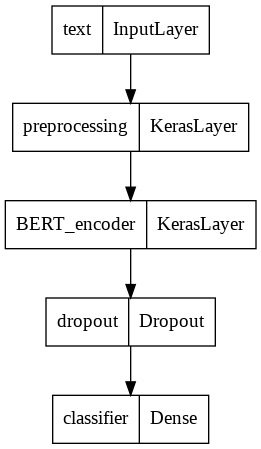

In [17]:
tf.keras.utils.plot_model(classifier_model)

Model training
You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

Loss function
Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use losses.BinaryCrossentropy loss function.

In [18]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

Optimizer
For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as AdamW.

For the learning rate (init_lr), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (num_warmup_steps). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

The BERT paper suggests a few heuristics for fine-tuning:

Batch Size: 16 or 32

Epochs: 2 to 4

Learning Rates for Adam: 5e-5, 3e-5,, or 2e-5.

In [19]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(ds_train).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

Loading the BERT model and training
Using the classifier_model you created earlier, you can compile the model with the loss, metric and optimizer.

In [20]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [21]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=ds_train,
                               validation_data=ds_val,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
782/782 [==============================] - 815s 1s/step - loss: 0.3914 - binary_accuracy: 0.7997 - val_loss: 0.2997 - val_binary_accuracy: 0.8778
Epoch 2/5
782/782 [==============================] - 787s 1s/step - loss: 0.2167 - binary_accuracy: 0.9129 - val_loss: 0.3311 - val_binary_accuracy: 0.8842
Epoch 3/5
782/782 [==============================] - 787s 1s/step - loss: 0.1176 - binary_accuracy: 0.9600 - val_loss: 0.4550 - val_binary_accuracy: 0.8868
Epoch 4/5
782/782 [==============================] - 786s 1s/step - loss: 0.0586 - binary_accuracy: 0.9834 - val_loss: 0.5422 - val_binary_accuracy: 0.8844
Epoch 5/5
782/782 [==============================] - 787s 1s/step - loss: 0.0310 - binary_accuracy: 0.9919 - val_loss: 0.6205 - val_binary_accuracy: 0.8870


Evaluate the model
Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [22]:
loss, accuracy = classifier_model.evaluate(ds_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

625/625 [==============================] - 215s 344ms/step - loss: 0.5947 - binary_accuracy: 0.8906
Loss: 0.5947439670562744
Accuracy: 0.8906499743461609


Plot the accuracy and loss over time
Based on the History object returned by model.fit(). You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


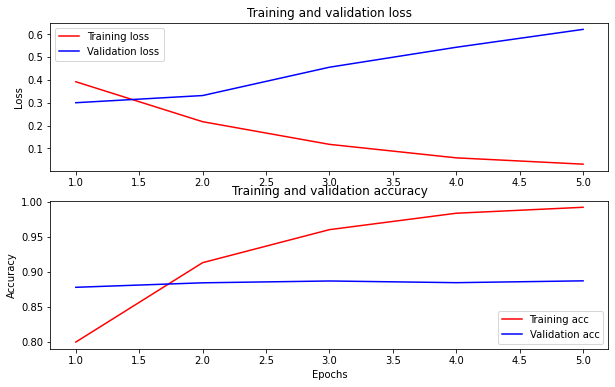

In [23]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

Here you can test your model on any sentence you want, just add to the examples variable below.

In [24]:
def print_my_examples(inputs, results):
    result_for_printing = \
        [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                            for i in range(len(inputs))]
    print(*result_for_printing, sep='\n')
    print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

#reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

#print('Results from the saved model:')
#print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the model in memory:
input: this is such an amazing movie! : score: 0.997260
input: The movie was great!           : score: 0.994038
input: The movie was meh.             : score: 0.042799
input: The movie was okish.           : score: 0.000319
input: The movie was terrible...      : score: 0.000201



Export for inference

Now you just save your fine-tuned model for later use.

In [25]:
# from google.colab import drive
# drive.mount('/content/gdrive')


In [26]:
# import os
# os.chdir('/content/gdrive/MyDrive/Works')

In [27]:
classifier_model.save('BERT_imdb.h5')